In [426]:
from surprise import BaselineOnly
from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
import os
from surprise import accuracy
from surprise.model_selection import KFold
# from surprise import SVD
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime
import random
from time import time
import math

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from multiprocessing import Pool
import timeit

my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

In [3]:
class RatingDataset:
    import numpy as np
    from scipy import sparse
    
    def __init__(self):
        self.rating_mat = None
        self.time_mat = None
        self._data_file_path = ''
        
        # list of raw user_IDs (dataset IDs)
        self.items = []
        self.users = []
        self.item_n = 0
        self.user_n = 0
        
        # maps raw user_id to user_iid(or innder id)
        self.user_to_iid = {}
        # maps user inner id to dataset raw ID
        self.user_to_ID = {}
        # maps raw item_id (dataset) to item_iid(or inner id)
        self.item_to_iid = {}
        # maps item inner id to dataset raw ID
        self.item_to_ID = {}
        
        # list of triples of (item, rating, timestamp) for each user_iid. 
        # TODO: In case there were no Timestamp in the data, pairs of (item, rating) will be kept
        self.user_ratings = []
        # list of pair of (user, rating) for each item_iid
        self.item_ratings = []
        
        
    def __get_line_format_indices(self, line_format):
        # specifying the order of 'user, item, rating, timestamp' in each line 
        lf_sp = line_format.split(' ')
        if len(lf_sp) != 4:
            raise Exception('''Bad line format!
            line_format should be space-separated and it should always specified by 
            "user item rating timestamp" with any order!''')
        user_idx = -1
        item_idx = -1
        rating_idx = -1
        timestamp_idx = -1
        for c in range(len(lf_sp)):
            if lf_sp[c] == 'user':
                user_idx = c
            elif lf_sp[c] == 'item':
                item_idx = c
            elif lf_sp[c] == 'rating':
                rating_idx = c
            elif lf_sp[c] == 'timestamp':
                timestamp_idx = c
            else:
                raise Exception('line_format must be exactly dictated by one of: (user/item/rating/timestamp) separated by sep!')
        
        return user_idx, item_idx, rating_idx, timestamp_idx
    
    
    '''
        Read the rating data from file and parse it and then make the dataset.
    '''
    def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating timestamp'):
        
        user_fmt_idx, item_fmt_idx, rating_fmt_idx, timestamp_fmt_idx = self.__get_line_format_indices(line_format)
        
        file = open(data_fn, 'r')
        
        # skip lines that are specified from input
        for _ in range(skip_lines):
            file.readline()
            
        # users list as in input file
        users_lin = []
        items_lin = []
        ratings_lin = []
        timestamps_lin = []
        for l in file:
            lsp = l.split(sep)
            user_id = lsp[user_fmt_idx]
            item_id = lsp[item_fmt_idx]
            rating = float(lsp[rating_fmt_idx])
            timestamp = int(lsp[timestamp_fmt_idx].strip('\n'))
            
            users_lin.append(user_id)
            items_lin.append(item_id)
            ratings_lin.append(rating)
            timestamps_lin.append(timestamp)
            
        self.users = list(set(users_lin))
        self.items = list(set(items_lin))
        
        self.user_n = len(self.users)
        self.item_n = len(self.items)
        
        # set the mappings
        for idx in range(self.user_n): 
            self.user_to_iid[self.users[idx]] = idx
        for idx in range(self.user_n):
            self.user_to_ID[idx] = self.users[idx] 
        for idx in range(self.item_n):
            self.item_to_iid[self.items[idx]] = idx 
        for idx in range(self.item_n):
            self.item_to_ID[idx] = self.items[idx] 
        
        # init rating matrix
        self.rating_mat = sparse.lil_matrix((self.user_n, self.item_n))
        self.time_mat = sparse.lil_matrix((self.user_n, self.item_n))
        for idx in range(len(users_lin)):
            user_iid = self.user_to_iid[users_lin[idx]]
            item_iid = self.item_to_iid[items_lin[idx]]
            rating = ratings_lin[idx]
            self.rating_mat[user_iid, item_iid] = rating
            self.time_mat[user_iid, item_iid] = timestamps_lin[idx]
            
            
    def list_users_ratings(self, rating_matrix):
        # finding the user and item ratings
        user_ratings = []
        for user_iid in range(self.user_n):
            # append a list for this user
            user_ratings.append([])
            user_nonze = np.nonzero(rating_matrix[user_iid])
            for item_iid in user_nonze[1]:
                # add items and its rating into the last user added to the list
                user_ratings[-1].append((item_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return user_ratings
    
            
    def list_items_ratings(self, rating_matrix):
        item_ratings = []
        for item_iid in range(self.item_n):
            # append a list for this item
            item_ratings.append([])
            item_nonze = np.nonzero(rating_matrix.T[item_iid])
            for user_iid in item_nonze[1]:
                # add users and its rating into the last item added to the list
                item_ratings[-1].append((user_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return item_ratings
        
            
    def train_test_split(self, test_percent=0.2, least_userlen_test=10):
        if test_percent > 1:
            raise Exception('test_percent should be between 0 and 1.')
            
        user_ratings = self.list_users_ratings(self.rating_mat)
        
        mat = sparse.lil_matrix((self.user_n, self.item_n))
        user_tests = {}
        n_users_in_test = 0
        n_ratings_in_test = 0
        n_ratings_in_train = 0
        
        for user_iid in range(self.user_n):
            len_u = len(user_ratings[user_iid])
            if len_u >= least_userlen_test:
                n_users_in_test += 1
                test_len = int(len_u * test_percent)
                test_set_u = list(range(len_u))
#                 print(test_len, len_u)
                random.shuffle(test_set_u)
                
                train_set_u = test_set_u[test_len:][:]
                test_set_u = test_set_u[:test_len][:]
                
#                 print(len(train_set_u))
                
                for ir_idx in train_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
                
                user_tests[user_iid] = []
                for ir_idx in test_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    user_tests[user_iid].append(ir)
                    n_ratings_in_test += 1
                    
            else: # if no test set should be seprated from ratings of this user
                for ir in user_ratings[user_iid]:
                    # ir = the pair of (item, rating)
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
    
        print('Number of users with some items in testset: %d' % n_users_in_test)
        print('Number of ratings in trainset: %d \t Number of ratings in testset: %d' % (n_ratings_in_train, n_ratings_in_test))
        return mat, user_tests

In [4]:
dataset = RatingDataset()
data_fn = 'data/ml_sample_6000.dat'
dataset.read_from_file(data_fn, skip_lines=0, line_format='user item rating timestamp', sep=',')

In [5]:
print(dataset.user_n)
print(dataset.item_n)

6000
14623


In [6]:
dataset.item_n

14623

In [7]:
# item_features_sampled.shape

In [8]:
# this many items don't have features! but not so many, then we'll skip them!
14623 - 14491

132

In [9]:
train_mat, user_tests = dataset.train_test_split(test_percent=0.2, least_userlen_test=10)

Number of users with some items in testset: 5193
Number of ratings in trainset: 449814 	 Number of ratings in testset: 109256


In [10]:
user_ratings = dataset.list_users_ratings(dataset.rating_mat)

In [11]:
dataset.rating_mat.shape

(6000, 14623)

### saving training and test sets

In [12]:
# test set
u_t_list = []

for uid in user_tests.keys():
    base_rec = pd.DataFrame(user_tests[uid])
    base_rec[2] = uid
    u_t_list.append(base_rec[[2,0,1]])

u_t_df = pd.concat(u_t_list, ignore_index=True)
u_t_df.to_csv('./RECSYS/test_recs_ml.csv', index=False, header=None)

In [13]:
# np.save('./RECSYS/trainmatrix_ml.npy', train_mat.toarray())
# sth = np.load('./recs/trainmatrix.npy')
# print (sth.shape)

# Evaluation
mat: Training data sparse matrix

user_tests: A dictionary for each user(key) stores the set of items that is positively rated(>= 4stars) by this user.

In [23]:
import math
# ground_truth: list of items ordered by time
def nDCG_Time(ground_truth, _recList):
    rec_num = len(_recList) #topK
    # ground_truth is already sorted by time
    idealOrder = ground_truth
    idealDCG = 0.0
    for j in range(min(rec_num, len(idealOrder))):
        idealDCG += ((math.pow(2.0, len(idealOrder) - j) - 1) / math.log(2.0 + j))

    recDCG = 0.0
    for j in range(rec_num):
        item = _recList[j]
        if item in ground_truth:
            rank = len(ground_truth) - ground_truth.index(item) # why ground truth?
            recDCG += ((math.pow(2.0, rank) - 1) / math.log(1.0 + j + 1))

    return (recDCG / idealDCG)


def Recall(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_test_set))


def Precision(_test_set, _recList):
    hit = len(set(_recList).intersection(set(_test_set)))
    return hit / float(len(_recList))


In [307]:
# Intra List Distance
def ILD(_recList):
    
    # convert inner ids to imdbids
#     _recList_if_ids = [InnerID_to_iiMatrixID[Inner_ID] for Inner_ID in _recList]
    _recList_imdb = [str(item_iid_to_imdb(iids)) for iids in _recList]
    
    _recList_if_ids = []
    c = 0
    for i in _recList_imdb:
        try:
            _recList_if_ids.append(from_imdb_itemSim[i])
        except KeyError as e:
            c += 1
# #             print(e)
#     if c > 0:
#         print(c)
# #     _recList_if_ids = [from_imdb_itemSim[i] for i in _recList_imdb]
        
    totalDisSimilarityPerUser = 0
    topK =  len(_recList)
    
    for item_i in _recList_if_ids:
        for item_j in _recList_if_ids:
             if (item_i != item_j):
                # this vector (i) and that vector (j)
                totalDisSimilarityPerUser += (1.0 - itemItemSimilarityByFeature[item_i, item_j])
    
    
    diversityPerUser = (totalDisSimilarityPerUser * 2.0) / (topK * (topK - 1.0))
    return (diversityPerUser)


def ENTROPY_(_recList):
    
    # given a user id, it calcualtes the entropy for the recommendation list of a user
        
    # convert inner ids to imdbids
    _recList_imdb = [str(item_iid_to_imdb(iids)) for iids in _recList] 

    # how many of each feature do we have? 
    # the result is a vector of column names and the count of that genre over all the movies
    feature_count_vector = item_features_df[item_features_df.index.isin(_recList_imdb)].sum(axis=0)
    
    # turn it back to a list of labels so we can pass it to entropy_()
    _recList_item_features = [i for i in feature_count_vector[feature_count_vector != 0].index for j in range(feature_count_vector[i])]

    # send the labels to the entropy_() to calculate the netropy over all the labels combined.
    return entropy_(_recList_item_features)

    
def entropy_(labels, base=None):
    from math import log, e
    """ Computes entropy of label distribution. """

    n_labels = len(labels)
    if n_labels <= 1:
        return 0

    value, counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0
    
    ent = 0.

    # Compute entropy
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)

    return ent

### Reading item-feature matrix

In [99]:
feat_dict = {'genres': ['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie', 'Adult'], 'popularity': ['pop', 'notpop'], 'year': ['new', 'old'], 'revenue': ['high', 'low'], 'runtime': ['short', 'long'], 'language': ['en', 'fr', 'es', 'de', 'ru', 'la', 'nl', 'cn', 'zh', 'hu', 'sq', 'it', 'ko', 'fa', 'da', 'gd', 'ja', 'ar', 'hr', 'bs', 'mn', 'ro', 'id', 'ms', 'mk', 'sv', 'he', 'kw', 'cs', 'nv', 'mi', 'tl', 'pl', 'ga', 'no', 'sk', 'vi', 'yi', 'pt', 'hi', 'ca', 'is', 'af', 'sr', 'bn', 'wo', 'cy', 'th', 'lv', 'sw', 'bg', 'el', 'ne', 'tr', 'km', 'fi', 'eo', 'uk', 'iu', 'ka', 'sh', 'bo', 'nb', 'ty', 'xx', 'si', 'as', 'gn', 'eu', 'az', 'mt', 'ur', 'zu', 'lo', 'xh', 'bm', 'cr', 'ps', 'so', 'ku', 'hy', 'oc', 'pa', 'to', 'ce', 'qu', 'be', 'am', 'tg', 'tt', 'se', 'ml', 'ta', 'co', 'gl', 'dz', 'rw', 'ht', 'kk', 'ln', 'my', 'et', 'sa', 'lt', 'fy', 'tk', 'sl', 'te', 'ny', 'st', 'sc', 'gu', 'ff', 'mr', 'ug', 'ay', 'ky', 'jv', 'br', 'sg', 'lb', 'ab', 'kn', 'uz', 'sm', 'ki', 'tn', 'fo', 'sn', 'bi', 'ha', 'ig', 'mh'], 'production_countries': ['US', 'DE', 'GB', 'FR', 'IT', 'ES', 'CN', 'AU', 'ZA', 'CA', 'CH', 'BE', 'JP', 'IR', 'NL', 'HK', 'TN', 'IE', 'DO', 'HR', 'RU', 'MK', 'AT', 'TW', 'NZ', 'MX', 'PL', 'PE', 'CU', 'LI', 'DK', 'PT', 'FI', 'SE', 'AR', 'IS', 'KR', 'RS', 'HU', 'CZ', 'IN', 'BR', 'GR', 'CD', 'SN', 'BF', 'RO', 'PH', 'VN', 'TT', 'BG', 'CL', 'NO', 'KZ', 'DZ', 'LU', 'GE', 'UA', 'BW', 'AW', 'IL', 'TR', 'EC', 'LB', 'MA', 'BA', 'BS', 'MY', 'BT', 'JM', 'PK', 'NP', 'CI', 'TH', 'NA', 'CM', 'CO', 'XC', 'UY', 'SI', 'LY', 'PR', 'SU', 'XG', 'SG', 'AF', 'MT', 'PA', 'EG', 'ZW', 'TJ', 'UZ', 'CR', 'KW', 'MQ', 'GH', 'AM', 'ID', 'MN', 'BO', 'MC', 'IQ', 'SK', 'CS', 'VE', 'LT', 'RW', 'PS', 'TD', 'PY', 'QA', 'EE', 'MO', 'ML', 'UM', 'LV', 'AE', 'AZ', 'KY', 'NI', 'LR', 'YU', 'ME', 'AO', 'BY', 'KH', 'MR', 'CY', 'BD', 'SY', 'KG', 'AL', 'TZ', 'KP', 'KE', 'JO', 'UG', 'SA', 'SO', 'GT', 'MG', 'ET', 'LK', 'PG', 'NG', 'LA', 'PF', 'AN', 'CG', 'MM', 'BM', 'SV', 'TF', 'WS', 'MD', 'BB', 'AQ', 'GI', 'BN', 'HN', 'GN']}

genres = ['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 
          'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 
          'Music', 'Documentary', 'Western', 'TV Movie', 'Adult']

In [25]:
item_features_df = pd.read_csv('./data/ML-26M/movie_genre_matrix.csv')
item_features_df.set_index('movieid', inplace=True)

# if the sum of genre values for a movie is zero, we assign 1 to the Drama genre, to avoid errors.
# Adding drama as the genre of those movies which does not have any genre labels
for idx, row in item_features_df.iterrows():
    if np.sum(row.loc[genres]) == 0:
        row.loc['Drama'] = 1

print(item_features_df.head())

           AE  AF  AL  AM  AN  AO  AQ  AR  AT  AU  ...  uk  ur  uz  vi  wo  \
movieid                                            ...                       
tt0000001   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
tt0000003   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
tt0000005   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
tt0000008   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
tt0000010   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   

           xh  xx  yi  zh  zu  
movieid                        
tt0000001   0   1   0   0   0  
tt0000003   0   1   0   0   0  
tt0000005   0   1   0   0   0  
tt0000008   0   1   0   0   0  
tt0000010   0   1   0   0   0  

[5 rows x 323 columns]


### Turning inner_ID to innerid for this item item similarity matrix

In [26]:
# Turning inner_ID to innerid for this item item similarity matrix
InnerID_to_iiMatrixID = {}
iiMatrixID_to_InnerID = {}

for i in range(item_features_df.shape[0]):
    iiMatrixID_to_InnerID[i] = item_features_df.index[i]
    InnerID_to_iiMatrixID[item_features_df.index[i]] = i

# print(InnerID_to_iiMatrixID[1606])

### item-item similarity based on features

In [27]:
# ---------------------------------------------------------------------------------------
# calcualte the item-item similarity matrix by its features
from sklearn.metrics.pairwise import cosine_similarity
itemItemSimilarityByFeature = cosine_similarity(item_features_df.values)
# its shape is (45332, 45332)

In [28]:
itemItemSimilarityByFeature.shape

(45332, 45332)

In [29]:
itemItemSimilarityByFeature[0, 1]

0.6681531047810608

### creating a mapping from item-id and item-imdb ids

In [30]:
imdb_ii = list(item_features_df.index)
from_imdb_itemSim = {}
from_itemSim_imdb = {}
for i in range(len(imdb_ii)):
    from_imdb_itemSim[imdb_ii[i]] = i
    from_itemSim_imdb[i] = imdb_ii[i]

In [31]:
import pandas as pd

df_meta = pd.read_csv('data/ML-26M/movies_metadata.csv', header=0, low_memory=False)
df_links = pd.read_csv('data/ML-26M/links.csv', header=0)
mv_id_to_imdb = {}

for idx, row in df_links.iterrows():
    mv_id_to_imdb[row[0]] = 'tt' + str(int(row[1])).zfill(7)
movie_all_ids = df_meta['id'].to_list()

def item_iid_to_imdb(item_iid):
    return mv_id_to_imdb[int(dataset.item_to_ID[item_iid])]


print(item_iid_to_imdb(2069))
df_meta[df_meta['imdb_id'] == str(item_iid_to_imdb(2069))]

tt0088001


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
9899,False,NaN,28000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,16551,tt0088001,en,Rhinestone,After a big-time country singer brags that she...,...,1984-06-22,21435321.0,111.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"She's bet everything, and we mean everything, ...",Rhinestone,False,4.9,33.0


## Adding movielens id to this dataframe

In [32]:
imdb_to_movie_id = {}
mv_id_to_imdb_keys = list(mv_id_to_imdb.keys())
mv_id_to_imdb_values = list(mv_id_to_imdb.values())

item_features_df_mvId_imdb = item_features_df.copy()
item_features_df_mvId_imdb['MovieLensID'] = -1

e = 0
for idx, row in item_features_df_mvId_imdb.iterrows():
    try:
        mv_id = mv_id_to_imdb_keys[mv_id_to_imdb_values.index(idx)]
        row[-1] = mv_id
    except ValueError:
        e += 1
print(e, len(item_features_df_mvId_imdb))
item_features_df_mvId_imdb.head(1)

60 45332


,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,...,ur,uz,vi,wo,xh,xx,yi,zh,zu,MovieLensID
movieid,,,,,,,,,,,,,,,,,,,,,
tt0000001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,172063


## Adding Inner item IDs to the feature data frame

In [33]:
item_features_df_mvId_imdb['Inner_ID'] = -1
e = 0
for idx, row in item_features_df_mvId_imdb.iterrows():
    try:
        row['Inner_ID'] = dataset.item_to_iid[str(row.loc['MovieLensID'])]
    except KeyError:
        e += 1
print(e, len(item_features_df_mvId_imdb) - e)
item_features_df_mvId_imdb.head(1)

30841 14491


,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,...,uz,vi,wo,xh,xx,yi,zh,zu,MovieLensID,Inner_ID
movieid,,,,,,,,,,,,,,,,,,,,,
tt0000001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,172063,-1


## Keeping only those movies which are in the sampled dataset

In [34]:
item_features_sampled = item_features_df_mvId_imdb[item_features_df_mvId_imdb['Inner_ID'] != -1].copy()

In [35]:
item_features_sampled.head(2)

,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,...,uz,vi,wo,xh,xx,yi,zh,zu,MovieLensID,Inner_ID
movieid,,,,,,,,,,,,,,,,,,,,,
tt0000417,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,32898,1000
tt0000420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,161111,12064


In [36]:
selected_cols = [item_features_sampled.columns[-1]] + item_features_sampled.columns[:-2].tolist()
selected_cols[:5]

['Inner_ID', 'AE', 'AF', 'AL', 'AM']

In [37]:
item_features_sampled[selected_cols].to_csv('./RECSYS/movie_iid_features_sampled.csv', index=False)

In [38]:
item_features_df.index.shape

(45332,)

In [39]:
item_features_sampled.index.shape

(14491,)

In [40]:
item_features_sampled.set_index('Inner_ID', inplace=True)
item_features_sampled_2 = item_features_sampled[item_features_df.columns].copy()

In [44]:
item_features_sampled_2.head(2)

,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,...,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
Inner_ID,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12064,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [45]:
item_features_sampled_2.index.shape

(14491,)

### base recommender

In [46]:
def recNMF_2(user_iid, _est, mat, topk):
    
    rated_before = np.nonzero(mat[user_iid, :])[1]
    estimations = _est[user_iid]
    estimations[rated_before] = 0 
    # you don't want to recommend the items to the user that have rated before duh!
    
    # top_items = np.argpartition(-estimations, topk)[:topk]
    top_items = np.argsort(-estimations)[:topk]
    top_ratings = -np.sort(-estimations)[:topk]
    
    return (user_iid, top_items, top_ratings)

# RECSYS

In [47]:
start = timeit.default_timer()
from sklearn.decomposition import NMF
feature_n = 40

mf = NMF(n_components=feature_n, init='random', random_state=2, tol=0.01,
         solver='cd', max_iter=1000, alpha=1, beta_loss='frobenius',
         l1_ratio=0)

user_f = mf.fit_transform(train_mat)
H = mf.components_
item_f = mf.components_.T

stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))
start = timeit.default_timer()
est = np.dot(user_f, item_f.T)
res = []

# Choose it to be 1000 instead of 10, and then the re-ranker will chose the final top 10
for u in range(dataset.user_n):
    res.append(recNMF_2(u, est, train_mat, 200))
    
user_recs_allinclude = {}
for x in res:
    user_recs_allinclude[x[0]] = x[1]

Process Time: 3.54 secs


### Saving the base recommendations into a file

In [48]:
u_rec_list = []
for i in range(len(res)):
    base_rec = pd.DataFrame(res[i][1:]).T
    base_rec[2] = res[i][0]
    u_rec_list.append(base_rec[[2,0,1]])

u_rec_df = pd.concat(u_rec_list, ignore_index=True)
u_rec_df.to_csv('./RECSYS/nmf_base_rec_ML.csv', index=False, header=None)

In [621]:
u_rec_df.columns = ['userid', 'itemid', 'rating']
u_rec_df.head()

,userid,itemid,rating
0,0,13196.0,2.283887
1,0,8839.0,2.271740
2,0,3759.0,2.226513
3,0,955.0,2.193102
4,0,4332.0,2.101415


## Evaluation

In [309]:
stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))

p = []
r = []
n = []
ild = []
ent = []

for u in user_tests.keys():
    if len(user_tests[u]) > 0:
        
        test_items = [t[0] for t in user_tests[u] if t[1] >= 4]
        
        if len(test_items) > 0:
            top_items = user_recs_allinclude[u][:10] # to be comparable with the other one, the list size should be the same e.g 10
            
            recall = Recall(test_items, top_items)
            precision = Precision(test_items, top_items)
            ndcg = nDCG_Time(test_items, top_items)

            # only top_items or recommendation list is needed for diversity
            diversity_ild = ILD(top_items)
            diversity_entropy = ENTROPY_(top_items)
            

            p.append(precision)
            r.append(recall)
            n.append(ndcg)
            ild.append(diversity_ild)
            ent.append(diversity_entropy)

print (" avg-precision %.3f\n avg-recall %.3f\n avg-nDCG %.3f\n avg-ILD %.3f\n avg-ENTROPY %.3f\n" %
       (np.average(p),np.average(r),np.average(n),np.average(ild),np.average(ent)))

Process Time: 606.07 secs
 avg-precision 0.165
 avg-recall 0.193
 avg-nDCG 0.128
 avg-ILD 0.679
 avg-ENTROPY 2.886



- User_recs_allinclude is a dictionary where the key is userid and the value is the top k recommendations.
- We pick the first 200 items for each user to give to the reranker.

# MMR RE-RANKER
#### argmax (lambda * recommendation score (u, i) - (1 - lambda) * Sigma cosine similarity(i, j))

In [54]:
import numpy as np
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler

In [55]:
import warnings
warnings.filterwarnings("error")
import sklearn


# u is userid, items of that user
# items is the list of all item-features
def mmr_opt(u, item_features, lam, top_k, w=None):
    
    new_rec_i = []
    new_rec_sc = []
    for i in range(len(res[u][1])):
        if res[u][1][i] in item_features.index:
            new_rec_i.append(res[u][1][i])
            new_rec_sc.append(res[u][2][i])
    new_rec_i = np.array(new_rec_i)
    new_rec_sc = np.array(new_rec_sc)
    
    # making sure that the scores are between zero and one across all users, similar to cosine score
    # otherwise how do we combine these two different scores
    scaler = MinMaxScaler()
    # scale the ratings for each user separately, does it matter at all?
    scaled_ratings = scaler.fit_transform(new_rec_sc.reshape(-1,1))[:,0]
    
    
    if w is not None:
        dists = sklearn.metrics.pairwise_distances(np.sqrt(w) * item_features.loc[new_rec_i], metric='cosine', n_jobs=1)
    else:
        dists = sklearn.metrics.pairwise_distances(item_features.loc[new_rec_i], metric='cosine', n_jobs=1)    


    c = 0
    s = []
    for k in range(top_k): # top_k means choose top k items for the final re-ranking.
        all_sc = []
        # iterate through the items that are recommended to user.
        # we choose the first 200 items.
        for rec_idx in range(len(new_rec_i)):
            p2 = 0
            for j in s:
                try:

                    # comparing item features
                    # items[i], items[j] and w are all vectors
                    # w is a vector the same length as items[i] and items[j]
#                     p = (1 - distance.cosine(item_features.loc[i].values,
#                                              item_features.loc[j].values,
#                                              w)) # weight
                    p = 1 - dists[rec_idx, new_rec_i.tolist().index(j)]
                    p2 += p
                except KeyError as e:
                    pass
              
                    
            
            # mmr objective function
            # sc = lam * (1 - distance.cosine(u, items[i])) - (1-lam) * p2
            r = scaled_ratings[rec_idx]
            
            # get the index of an itemid and get the rating related to it
            sc = lam * r - (1-lam) * p2
            # find the index of a user id and then go to that index to retrieve the score
            all_sc.append(sc) # 0.1 0.5 0.2
            
            
            
        sc_asorted = np.argsort(all_sc)[::-1] # [1, 2, 0]
        sc_idx = 0
        top_item = new_rec_i[sc_asorted[0]]
        
        # if top item already exists in the list, pick the second best item or the third best item
        while top_item in s:
            top_item = new_rec_i[sc_asorted[sc_idx]]
            sc_idx += 1
        s.append(top_item)

    top_ratings = [new_rec_sc[list(new_rec_i).index(i)] for i in s]
    
    return (u, s, top_ratings)

### saving the reranker results

In [56]:
def save_recommendations(recommendations, filename):
    u_rec_list = []
    for i in range(len(recommendations)):
        base_rec = pd.DataFrame(recommendations[i][1][1:]).T
        base_rec[2] = recommendations[i][1][0] # userid
        u_rec_list.append(base_rec[[2,0,1]])

    u_rec_df = pd.concat(u_rec_list, ignore_index=True)
    u_rec_df.to_csv('./RECSYS/ml_results/' + filename, index=False, header=None)
    return

# User tolerance matrix - normalized

In [91]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# ------------------------------------------------------------------------------------------------------------------------------------------------------
# Calculating user tolerance weight as a dictionary e.g. {userid: {f1: entropy, f2: entropy, f3:entropy}}

userid_tolerance_dict = {} # key:userid, & value: a dictionary of genre : tolerance
for userid in range(dataset.user_n):
    
    # creating an empty dictionary
    empty_dict = {}
    for k in feat_dict.keys():
        empty_dict[k] = []

    # inner ids
    items_rated_before = np.nonzero(train_mat[userid, :])[1]
    i_f = item_features_sampled_2[item_features_sampled_2.index.isin(items_rated_before)].sum()
    
    for i in range(i_f.index.shape[0]):
        for k in feat_dict.keys():
            if i_f.index[i] in feat_dict[k]:
                empty_dict[k].extend([i_f.index[i]] * int(i_f[i]))

    # calculate entropy for each user over all the features
    # this is problematic for users who have a short profile.
    tolerance_dict = {} # feature: entropy
    
    for k, v in empty_dict.items():
        tolerance_dict[k] = entropy_(v)

    # {userid: {feature: entropy}}
    userid_tolerance_dict[userid] = tolerance_dict

print('# users: ', len(userid_tolerance_dict), '\n')

print("\ncalculate user feature dictionary\n")
print('example - user tolerance for user #0: \n', userid_tolerance_dict[0], '\n')

# ------------------------------------------------------------------------------------------------------------------------------------------------------
# creating a user,super-genre, entropy matrix
# Turning the userid_tolerance_dict into a matrix where each row is user id and columns are features and the values are entropies. 
# We normalize the entropy based on all the values. We transform them to valeus between 0 and 1.

from sklearn.feature_extraction import DictVectorizer

# Create DictVectorizer object
dictvectorizer = DictVectorizer(sparse=False)

# Convert dictionary into feature matrix
features = dictvectorizer.fit_transform(userid_tolerance_dict.values())

# get column names
print ('feature names => ', dictvectorizer.get_feature_names(),'\n')
print("\ncalculating user feature matrix\n")
print ('example - 5 rows of this matrix\n', features[:5], '\n')

# ------------------------------------------------------------------------------------------------------------------------------------------------------
# Transform the whole tolerance (feature) matrix between 0 and 1 - across all users
# (X - MIN / MAX - MIN) * (NEW_MAX - NEW_MIN) + NEW_MIN
feature_max = np.max(features)
feature_min = np.min(features)
new_min = 0
new_max = 1


# print(feature_max, feature_min)
sc = (features - feature_min) / (feature_max - feature_min)
userid_tolerance_normed = sc * (new_max - new_min) + new_min
print("\nnormalize the user feature matrix between 0 and 1:\n")
print('example - 5 rows of this transformed matrix\n', userid_tolerance_normed[:5], '\n')

# ------------------------------------------------------------------------------------------------------------------------------------------------------
# instead of zero we initialize the vector with epsilon, 
# And to avoid divide by zero and to allow a little bit of room for diversity in other categories
import sys
my_epsilon = sys.float_info.epsilon # 2.220446049250313e-16
userid_tolerance_normed += my_epsilon

print("\nadding an epsilon to all the enteries of the matrix to avoid division by zero. \n")
print(userid_tolerance_normed[:5])

# feature_names = dictvectorizer.get_feature_names()
# print (feature_names)
# print(feature_names.index('popularity'))
# print(userid_tolerance_normed[2])
# print(userid_tolerance_dict[2])

# ------------------------------------------------------------------------------------------------------------------------------------------------------
# turn it into a dataframe
userid_tolerance_normed_df =pd.DataFrame(userid_tolerance_normed)
userid_tolerance_normed_df.columns=feature_names
print("\nfinal dataframe - user feature tolerance df\n")
userid_tolerance_normed_df.head()

# users:  6000 


calculate user feature dictionary

example - user tolerance for user #0: 
 {'genres': 2.4858723600290955, 'popularity': 0.05709648434008767, 'year': 0.6524697906601717, 'revenue': 0.4927383828989331, 'runtime': 0.3922483495571202, 'language': 2.004106923415363, 'production_countries': 1.4610624817773068} 

feature names =>  ['genres', 'language', 'popularity', 'production_countries', 'revenue', 'runtime', 'year'] 


calculating user feature matrix

example - 5 rows of this matrix
 [[2.48587236 2.00410692 0.05709648 1.46106248 0.49273838 0.39224835
  0.65246979]
 [2.23472767 1.76996079 0.18920898 1.41271546 0.57885864 0.18920898
  0.43339887]
 [2.31779033 1.32911476 0.53359897 1.32158376 0.49647248 0.69304799
  0.62980642]
 [0.69314718 0.         0.         0.         0.         0.
  0.        ]
 [2.17908498 1.04421426 0.         0.82229001 0.54887438 0.48691271
  0.63651417]] 


normalize the user feature matrix between 0 and 1:

example - 5 rows of this transformed m

,genres,language,popularity,production_countries,revenue,runtime,year
0,0.918332,7.403578e-01,2.109260e-02,5.397461e-01,1.820276e-01,1.449045e-01,2.410356e-01
1,0.825554,6.538594e-01,6.989764e-02,5.218858e-01,2.138421e-01,6.989764e-02,1.601063e-01
2,0.856239,4.910020e-01,1.971223e-01,4.882199e-01,1.834070e-01,2.560260e-01,2.326633e-01
3,0.256063,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16
4,0.804998,3.857539e-01,2.220446e-16,3.037706e-01,2.027653e-01,1.798754e-01,2.351413e-01


### plotting user tolerance for different features

Text(0, 0.5, '% Users')

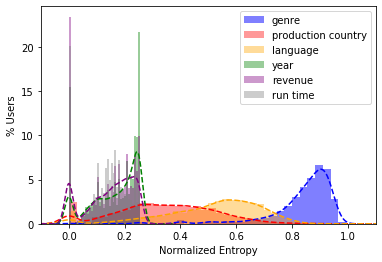

In [92]:
fig, ax = plt.subplots()
ax.hist(sorted(userid_tolerance_normed_df['genres']), color = 'blue', alpha=0.5,
             bins = int(180/5), label='genre', density=True)

ax.hist(sorted(userid_tolerance_normed_df['production_countries']), color = 'red',
             bins = int(180/5), alpha=0.4, label='production country', density=True)

ax.hist(sorted(userid_tolerance_normed_df['language']), color = 'orange',
             bins = int(180/5), alpha=0.4, label='language', density=True)

ax.hist(sorted(userid_tolerance_normed_df['year']), color = 'green',
             bins = int(180/5), alpha=0.4, label='year', density=True)

ax.hist(sorted(userid_tolerance_normed_df['revenue']), color = 'purple',
             bins = int(180/5), alpha=0.4, label='revenue', density=True)


ax.hist(sorted(userid_tolerance_normed_df['runtime']), color = 'gray',
             bins = int(180/5), alpha=0.4, label='run time', density=True)

plt.legend()
userid_tolerance_normed_df['genres'].plot.kde(ax=ax, legend=False, color='blue', ls='--')
userid_tolerance_normed_df['production_countries'].plot.kde(ax=ax, legend=False, color='red', ls='--')
userid_tolerance_normed_df['language'].plot.kde(ax=ax, legend=False, color='orange', ls='--')
userid_tolerance_normed_df['year'].plot.kde(ax=ax, legend=False, color='green', ls='--')
userid_tolerance_normed_df['revenue'].plot.kde(ax=ax, legend=False, color='purple', ls='--')

ax.set_xlim([-0.1,1.1])
ax.set_xlabel('Normalized Entropy')
ax.set_ylabel('% Users')
# plt.savefig('./RECSYS//ml_u_ent_dist_all_cats.png', dpi=300)

## create user tolerance vectors for each user, its length should be as much as the all the feature dimensions.

define user_tolerance_vector, create a vector as long as the item_features_df, keep the column orders so when cosine.distance calculates the weigthed distance, it multiplies it by these numbers. A vector of all 0s, then add the entropy to those indexes.
e.g.
[0, 0, 0, 0] and it is ['Action', 'old', 'Thriller', 'US]
then look for the entropy vector for each user, based on her profile [0.2, 0, 0.1, 0.9]
then the user entropy will be added to the vector of zeros.
We have 323 features. So the length of each vector is 323.

In [93]:
user_genre_matrix = []
for userid, row in userid_tolerance_normed_df.iterrows():
    
    user_tolerance_vector = [0.0] * item_features_sampled_2.columns.values.shape[0]
    
    for feature in userid_tolerance_normed_df.columns.values.tolist():
        
        f_tol = userid_tolerance_normed_df.loc[userid, feature]
        
        sub_feat_indexes = [item_features_sampled_2.columns.get_loc(sf) for sf in feat_dict[feature]]
        
        for sf_id in sub_feat_indexes:
            user_tolerance_vector[sf_id] += f_tol
        
    # insert userid at the beginning of each vector
    user_tolerance_vector.insert(0, userid)
    user_genre_matrix.append(user_tolerance_vector)  
        
print (len(user_genre_matrix))
user_genre_matrix_df = pd.DataFrame(user_genre_matrix)
user_genre_matrix_df.columns = ['userid'] + item_features_sampled_2.columns.values.tolist()
user_genre_matrix_df.set_index('userid', inplace=True)
user_genre_matrix_df.head()


user_genre_matrix_df.to_csv('./RECSYS/user_genre_tol_matrix_normalized_ML.csv')

6000


In [94]:
print(userid_tolerance_normed[0][feature_names.index('genres')])
print (userid_tolerance_normed[0])
print(feature_names)

0.9183317192158403
[0.91833172 0.74035779 0.0210926  0.53974614 0.18202756 0.1449045
 0.24103559]
['genres', 'language', 'popularity', 'production_countries', 'revenue', 'runtime', 'year']


# Variations of MMR

In [124]:
# ----------------------------------------------- RECSYS + Content-based MMR reranker ----------------------------------------------- 
# start = timeit.default_timer()
# for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.93, 0.95, 0.97, 0.99, 1.0]:
    
#     print(lam)
#     top_k = 10
#     rr_recs = []
    
#     def compute_mmr(u):
#         return (u, mmr_opt(u, item_features_sampled_2, lam, top_k))

#     pool = Pool(processes=20)
#     rr_recs = pool.map(compute_mmr, list(range(dataset.user_n)))
#     pool.close()
#     pool.join()
    
#     save_recommendations(rr_recs, 'rec_MMR_lam%s.csv'%lam)

# stop = timeit.default_timer()
# print('Process Time: %.2f secs' % (stop - start))



# ----------------------------------------------- RECSYS + MMR + TOLERANCE WEIGHTS ----------------------------------------------- 
# start = timeit.default_timer()
# for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.93, 0.95, 0.97, 0.99, 1.0]:
    
#     print(lam)
#     top_k = 10
#     mmr_tol_recs = []
    
#     def compute_mmr(u):
#         # get the user specific tolerance weight 
#         w = user_genre_matrix_df.loc[u]
#         return (u, mmr_opt(u, item_features_sampled_2, lam, top_k, w))

#     pool = Pool(processes=5)
#     mmr_tol_recs = pool.map(compute_mmr, list(range(dataset.user_n)))
#     pool.close()
#     pool.join()  
    
#     save_recommendations(mmr_tol_recs, 'rec_tol_MMR_lam%s.csv'%lam)

# stop = timeit.default_timer()
# print('Process Time: %.2f secs' % (stop - start))


# ----------------------------------------------- RECSYS + MMR + FAIRNESS WEIGHTS ----------------------------------------------- 
# start = timeit.default_timer()
# for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.87, 0.9, 0.93, 0.95, 0.97, 0.99, 1.0]:
    
#     print(lam)
#     top_k = 10

#     def compute_mmr_selective_fairness(u):
        
#         f_w = fairness_weights_man.T.to_numpy()[0]
#         return (u, mmr_opt(u, item_features_sampled_2, lam, top_k, f_w))

#     pool = Pool(processes=20) 
#     user_recs_ent_fairness = pool.map(compute_mmr_selective_fairness, list(range(dataset.user_n)))
#     pool.close()
#     pool.join()
#     pool.terminate()

#     save_recommendations(user_recs_ent_fairness, 'rec_MMR_fair_lam%s_twoFeatures100.csv'%lam)

# stop = timeit.default_timer()
# print('Process Time: %.2f secs' % (stop - start))


# ------------------------- OFAiR: RECSYS + MMR + FAIRNESS WEIGHTS +  TOLERANCE WEIGHTS ------------------------------------------ 
# start = timeit.default_timer()
# for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,0.87, 0.9,0.93, 0.95, 0.97, 0.99, 1.0]:
    
#     print(lam)
#     top_k = 10

#     def compute_mmr_selective_fairness(u):
        
#         # get the user specific tolerance weight 
#         u_tol_w = fairness_weights_man.T.to_numpy()[0] * user_genre_matrix_df.loc[u].to_numpy()
        
#         return (u, mmr_opt(u, item_features_sampled_2, lam, top_k, u_tol_w))


#     pool = Pool(processes=20)
#     user_recs_ent_fairness = pool.map(compute_mmr_selective_fairness, list(range(dataset.user_n)))
#     pool.close()
#     pool.join()
#     pool.terminate()

#     save_recommendations(user_recs_ent_fairness, 'rec_tol_fair_MMR_lam%s.csv'%lam)

# stop = timeit.default_timer()
# print('Process Time: %.2f secs' % (stop - start))

### OFAiR: RECSYS + MMR + TOLERANCE WEIGHTS + FAIRNESS WEIGHT

In [100]:
# feat_dict = {'genres': ['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie', 'Adult'], 'popularity': ['pop', 'notpop'], 'year': ['new', 'old'], 'revenue': ['high', 'low'], 'runtime': ['short', 'long'], 'language': ['en', 'fr', 'es', 'de', 'ru', 'la', 'nl', 'cn', 'zh', 'hu', 'sq', 'it', 'ko', 'fa', 'da', 'gd', 'ja', 'ar', 'hr', 'bs', 'mn', 'ro', 'id', 'ms', 'mk', 'sv', 'he', 'kw', 'cs', 'nv', 'mi', 'tl', 'pl', 'ga', 'no', 'sk', 'vi', 'yi', 'pt', 'hi', 'ca', 'is', 'af', 'sr', 'bn', 'wo', 'cy', 'th', 'lv', 'sw', 'bg', 'el', 'ne', 'tr', 'km', 'fi', 'eo', 'uk', 'iu', 'ka', 'sh', 'bo', 'nb', 'ty', 'xx', 'si', 'as', 'gn', 'eu', 'az', 'mt', 'ur', 'zu', 'lo', 'xh', 'bm', 'cr', 'ps', 'so', 'ku', 'hy', 'oc', 'pa', 'to', 'ce', 'qu', 'be', 'am', 'tg', 'tt', 'se', 'ml', 'ta', 'co', 'gl', 'dz', 'rw', 'ht', 'kk', 'ln', 'my', 'et', 'sa', 'lt', 'fy', 'tk', 'sl', 'te', 'ny', 'st', 'sc', 'gu', 'ff', 'mr', 'ug', 'ay', 'ky', 'jv', 'br', 'sg', 'lb', 'ab', 'kn', 'uz', 'sm', 'ki', 'tn', 'fo', 'sn', 'bi', 'ha', 'ig', 'mh'], 'production_countries': ['US', 'DE', 'GB', 'FR', 'IT', 'ES', 'CN', 'AU', 'ZA', 'CA', 'CH', 'BE', 'JP', 'IR', 'NL', 'HK', 'TN', 'IE', 'DO', 'HR', 'RU', 'MK', 'AT', 'TW', 'NZ', 'MX', 'PL', 'PE', 'CU', 'LI', 'DK', 'PT', 'FI', 'SE', 'AR', 'IS', 'KR', 'RS', 'HU', 'CZ', 'IN', 'BR', 'GR', 'CD', 'SN', 'BF', 'RO', 'PH', 'VN', 'TT', 'BG', 'CL', 'NO', 'KZ', 'DZ', 'LU', 'GE', 'UA', 'BW', 'AW', 'IL', 'TR', 'EC', 'LB', 'MA', 'BA', 'BS', 'MY', 'BT', 'JM', 'PK', 'NP', 'CI', 'TH', 'NA', 'CM', 'CO', 'XC', 'UY', 'SI', 'LY', 'PR', 'SU', 'XG', 'SG', 'AF', 'MT', 'PA', 'EG', 'ZW', 'TJ', 'UZ', 'CR', 'KW', 'MQ', 'GH', 'AM', 'ID', 'MN', 'BO', 'MC', 'IQ', 'SK', 'CS', 'VE', 'LT', 'RW', 'PS', 'TD', 'PY', 'QA', 'EE', 'MO', 'ML', 'UM', 'LV', 'AE', 'AZ', 'KY', 'NI', 'LR', 'YU', 'ME', 'AO', 'BY', 'KH', 'MR', 'CY', 'BD', 'SY', 'KG', 'AL', 'TZ', 'KP', 'KE', 'JO', 'UG', 'SA', 'SO', 'GT', 'MG', 'ET', 'LK', 'PG', 'NG', 'LA', 'PF', 'AN', 'CG', 'MM', 'BM', 'SV', 'TF', 'WS', 'MD', 'BB', 'AQ', 'GI', 'BN', 'HN', 'GN']}

In [102]:
# item_features_sampled_2.head()

### Feature count of all the movies (items) in the whole data

### <font color='red'>IMP: let's define the fairness dimensions and underrepresented groups based on the recommendation algorithms, not the training data.</font>

In [624]:
# item_features_sampled_2.head()

In [625]:
# items = list(range(dataset.item_n))
# print(dataset.item_n)

items = u_rec_df['itemid'].to_list()

training_item_features_df_unique = item_features_sampled_2[item_features_sampled_2.index.isin(items)]
training_item_features_df_unique.head()

,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,AW,AZ,Action,Adult,Adventure,Animation,BA,BB,BD,BE,BF,BG,BM,BN,BO,BR,BS,BT,BW,BY,CA,CD,CG,CH,CI,CL,CM,CN,CO,CR,CS,CU,CY,CZ,Comedy,Crime,DE,DK,DO,DZ,Documentary,Drama,EC,EE,EG,ES,ET,FI,FR,Family,Fantasy,Foreign,GB,GE,GH,GI,GN,GR,GT,HK,HN,HR,HU,History,Horror,ID,IE,IL,IN,IQ,IR,IS,IT,JM,JO,JP,KE,KG,KH,KP,KR,KW,KY,KZ,LA,LB,LI,LK,LR,LT,LU,LV,LY,MA,MC,MD,ME,MG,MK,ML,MM,MN,MO,MQ,MR,MT,MX,MY,Music,Mystery,NA,NG,NI,NL,NO,NP,NZ,PA,PE,PF,PG,PH,PK,PL,PR,PS,PT,PY,QA,RO,RS,RU,RW,Romance,SA,SE,SG,SI,SK,SN,SO,SU,SV,SY,Science Fiction,TD,TF,TH,TJ,TN,TR,TT,TV Movie,TW,TZ,Thriller,UA,UG,UM,US,UY,UZ,VE,VN,WS,War,Western,XC,XG,YU,ZA,ZW,ab,af,am,ar,as,ay,az,be,bg,bi,bm,bn,bo,br,bs,ca,ce,cn,co,cr,cs,cy,da,de,dz,el,en,eo,es,et,eu,fa,ff,fi,fo,fr,fy,ga,gd,gl,gn,gu,ha,he,hi,high,hr,ht,hu,hy,id,ig,is,it,iu,ja,jv,ka,ki,kk,km,kn,ko,ku,kw,ky,la,lb,ln,lo,long,low,lt,lv,mh,mi,mk,ml,mn,mr,ms,mt,my,nb,ne,new,nl,no,notpop,nv,ny,oc,old,pa,pl,pop,ps,pt,qu,ro,ru,rw,sa,sc,se,sg,sh,short,si,sk,sl,sm,sn,so,sq,sr,st,sv,sw,ta,te,tg,th,tk,tl,tn,to,tr,tt,ty,ug,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
Inner_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
11936,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4018,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11483,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [626]:
all_item_feature_count = np.sum(training_item_features_df_unique.to_numpy(), axis=0)
all_item_feature_count = pd.DataFrame([all_item_feature_count], columns=training_item_features_df_unique.columns)
all_item_feature_count = pd.DataFrame(all_item_feature_count.T).rename(columns={0:'count'})
all_item_feature_count.index.name = 'cat'
all_item_feature_count.T

cat,AE,AF,AL,AM,AN,AO,AQ,AR,AT,AU,AW,AZ,Action,Adult,Adventure,Animation,BA,BB,BD,BE,BF,BG,BM,BN,BO,BR,BS,BT,BW,BY,CA,CD,CG,CH,CI,CL,CM,CN,CO,CR,CS,CU,CY,CZ,Comedy,Crime,DE,DK,DO,DZ,Documentary,Drama,EC,EE,EG,ES,ET,FI,FR,Family,Fantasy,Foreign,GB,GE,GH,GI,GN,GR,GT,HK,HN,HR,HU,History,Horror,ID,IE,IL,IN,IQ,IR,IS,IT,JM,JO,JP,KE,KG,KH,KP,KR,KW,KY,KZ,LA,LB,LI,LK,LR,LT,LU,LV,LY,MA,MC,MD,ME,MG,MK,ML,MM,MN,MO,MQ,MR,MT,MX,MY,Music,Mystery,NA,NG,NI,NL,NO,NP,NZ,PA,PE,PF,PG,PH,PK,PL,PR,PS,PT,PY,QA,RO,RS,RU,RW,Romance,SA,SE,SG,SI,SK,SN,SO,SU,SV,SY,Science Fiction,TD,TF,TH,TJ,TN,TR,TT,TV Movie,TW,TZ,Thriller,UA,UG,UM,US,UY,UZ,VE,VN,WS,War,Western,XC,XG,YU,ZA,ZW,ab,af,am,ar,as,ay,az,be,bg,bi,bm,bn,bo,br,bs,ca,ce,cn,co,cr,cs,cy,da,de,dz,el,en,eo,es,et,eu,fa,ff,fi,fo,fr,fy,ga,gd,gl,gn,gu,ha,he,hi,high,hr,ht,hu,hy,id,ig,is,it,iu,ja,jv,ka,ki,kk,km,kn,ko,ku,kw,ky,la,lb,ln,lo,long,low,lt,lv,mh,mi,mk,ml,mn,mr,ms,mt,my,nb,ne,new,nl,no,notpop,nv,ny,oc,old,pa,pl,pop,ps,pt,qu,ro,ru,rw,sa,sc,se,sg,sh,short,si,sk,sl,sm,sn,so,sq,sr,st,sv,sw,ta,te,tg,th,tk,tl,tn,to,tr,tt,ty,ug,uk,ur,uz,vi,wo,xh,xx,yi,zh,zu
count,3,0,0,0,0,0,0,9,9,64,0,0,818,0,654,222,2,0,0,19,0,1,0,0,0,8,1,0,2,0,131,0,0,10,0,1,1,29,1,0,0,1,1,22,1316,577,227,21,0,0,92,1846,1,0,0,42,0,6,252,395,370,17,522,0,0,0,0,3,1,38,0,1,8,145,319,1,27,2,23,0,4,5,83,1,0,93,0,0,0,0,11,0,0,2,0,0,1,1,0,1,7,0,1,2,0,0,0,0,1,0,0,0,0,0,0,3,18,1,120,320,0,0,0,20,10,0,27,0,4,0,0,0,1,12,0,0,3,0,0,2,2,25,0,687,0,25,6,2,0,0,0,1,0,0,469,0,0,7,0,0,5,1,9,5,0,962,2,0,0,3008,0,0,0,0,0,128,80,1,0,0,9,0,0,7,0,50,0,0,2,0,2,0,0,2,3,1,2,0,0,40,1,0,32,0,15,234,0,19,3375,4,306,2,1,12,0,5,0,416,0,8,6,1,1,0,0,25,22,2137,3,0,46,3,2,0,4,196,2,121,1,1,0,1,2,0,28,0,1,0,51,0,0,0,2879,1542,0,1,0,3,1,1,3,0,3,1,1,0,1,2680,12,9,431,4,1,0,999,1,28,3248,1,60,1,10,168,0,1,0,0,0,3,800,1,3,0,0,0,3,5,5,1,24,7,3,0,0,28,0,2,0,0,14,1,1,0,8,11,0,15,0,2,5,16,80,3


In [627]:
all_item_feature_count['count'].sum(axis=0)

34773

In [628]:
freq_count = pd.DataFrame(columns=['cat', 'count'])

for key in feat_dict.keys():
    a_df = all_item_feature_count[all_item_feature_count.index.isin(feat_dict[key])]
    a_df_perc = a_df * 100.0 / a_df.sum() # divide by the total number of occurences in that catgory.
    a_df_perc = a_df_perc.reset_index(inplace=False)
    a_df_perc.columns = ['cat', 'count']
    freq_count = pd.concat([freq_count, a_df_perc], axis = 0)

freq_count.sort_values(by='cat', inplace=True)
freq_count.set_index('cat', inplace=True)
genre_all_item_count = freq_count

In [629]:
genre_all_item_count[genre_all_item_count.index.isin(feat_dict['genres'])].T

cat,Action,Adult,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
count,8.569034,0.0,6.851037,2.325581,13.785879,6.044417,0.963754,19.337943,4.137859,3.875969,0.178085,1.518961,3.341714,1.257071,3.352189,7.196732,4.913053,0.09428,10.077519,1.340876,0.838047


In [630]:
genre_all_item_count['count'].sum(axis=0)
# we have 7 features: ['genres', 'language', 'popularity', 'production_countries', 'revenue', 'runtime', 'year']
# we calculated the percentage for each separately

700.0

In [631]:
genre_all_item_count[genre_all_item_count.index.isin(feat_dict['genres'])].sum()

count    100.0
dtype: float64

Text(0, 0.5, 'percentage')

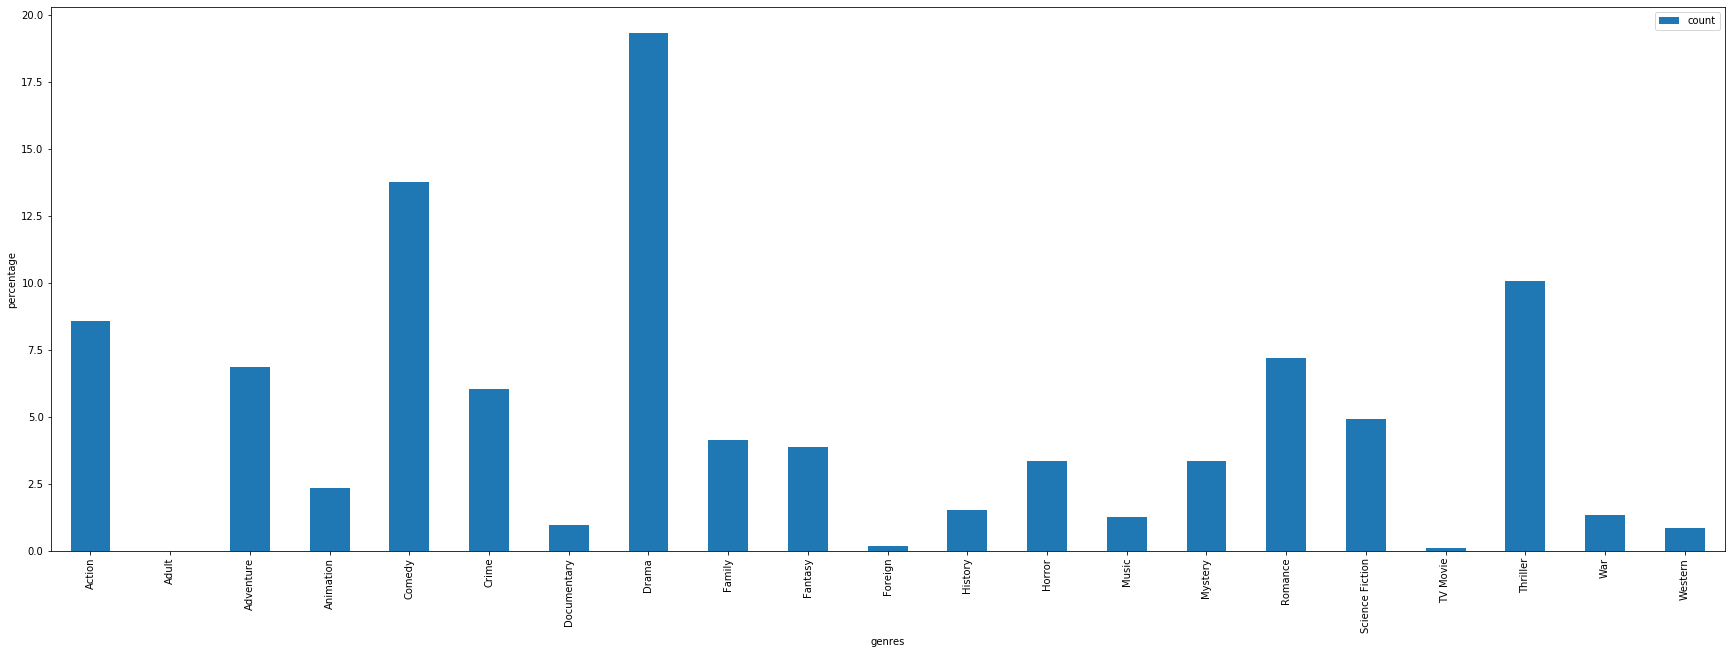

In [632]:
countries_df = genre_all_item_count[genre_all_item_count.index.isin(feat_dict['genres'])]
countries_df.plot(kind='bar', figsize=(30, 10))
plt.xlabel('genres')
plt.ylabel('percentage')

In [633]:
pd.set_option('display.max_columns', None)

### setting fairness dimension weights

In [634]:
'''setting two dimensions's fairness weights'''
# saving the country names into a file, since it's too long.
# pd.DataFrame(feat_dict['production_countries']).to_csv('./RECSYS/countries.csv', index=False, header=None)

# fairness_weights_man = genre_all_item_count.T.copy()
# genre_dist_rerankings = []

# fairness_weights_man[feat_dict['genres']] = 1
# for fee in ['Horror', 'Music', 'History', 'Mystery']:
#     fairness_weights_man[fee] = 100

# fairness_weights_man[feat_dict['production_countries']] = 1
# for fee in ['CA', 'DE', 'ES', 'HK']:
#     fairness_weights_man[fee] = 100

# fairness_weights_man = fairness_weights_man.T


"setting two dimensions's fairness weights"

In [635]:
# fairness_weights_man = genre_all_item_count.T.copy()
# genre_dist_rerankings = []

# fairness_weights_man[feat_dict['genres']] = 1
# for fee in ['Horror', 'Music', 'History', 'Mystery']:
#     fairness_weights_man[fee] = 100


# fairness_weights_man = fairness_weights_man.T

In [636]:
# fairness_weights_man.T

# OFAiR

In [637]:
# fairness_weights_man.T.to_numpy()[0] * user_genre_matrix_df.loc[0].to_numpy()

### given the previous experiments, let's choose lambda = 0.8 since we don't loose much accuracy while achieving a great deal of diversity. Recall that higher lambdas pust more focus on the accuracy. 

In [638]:
# start = timeit.default_timer()
# # for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,0.87, 0.9,0.93, 0.95, 0.97, 0.99, 1.0]:
# lam = 0.8  
# print(lam)

# top_k = 10

# def compute_ofair(u):
#     # get the user specific tolerance weight 
#     u_tol_w = fairness_weights_man.T.to_numpy()[0] * user_genre_matrix_df.loc[u].to_numpy()
#     return (u, mmr_opt(u, item_features_sampled_2, lam, top_k, u_tol_w))


# pool = Pool(processes=5)
# user_recs_ofair = pool.map(compute_ofair, list(range(dataset.user_n)))
# pool.close()
# pool.join()
# pool.terminate()

# save_recommendations(user_recs_ent_fairness, 'rec_tol_fair_MMR_lam%s.csv'%lam)

# stop = timeit.default_timer()
# print('Process Time: %.2f secs' % (stop - start))

In [639]:
# mem = {}
# for k in feat_dict.keys():
#     mem[k] = {'pro':[], 'draw': 0.0}
    
#     thedimensions = genre_all_item_count[genre_all_item_count.index.isin(feat_dict[k])]
#     # print(thedimensions)

#     # underrepresented dims are those whose frequencies are less than the MEDIAN of the list
#     underrep_dims = thedimensions[thedimensions['count'] <= np.median(thedimensions)].index.tolist()
    
#     mem[k]['pro'].extend(underrep_dims)
    
# # mem

In [640]:
import random

def compute_ofair(u):
    # ----------------- randomly choose a dimension and detect underreps -------------------------------------------
    # choose a feature to fix fairness in its dimensions e.g. choose genre, boost Horror, Music, ...
    thefeature = random.choice(list(feat_dict.keys()))
#     print(thefeature)
    
    #update the memory dictionary
#     mem[thefeature]['draw'] += 1.0    
    
    # separate the dataframe
    thedimensions = genre_all_item_count[genre_all_item_count.index.isin(feat_dict[thefeature])]
    # print(thedimensions)

    # underrepresented dims are those whose frequencies are less than the first quantile of the list
#     underrep_dims = thedimensions[thedimensions['count'] <= np.median(thedimensions)].index.tolist()
    underrep_dims = thedimensions[thedimensions['count'] <= float(thedimensions.quantile(0.23))].index.tolist()
#     print(underrep_dims)
    
    # ----------------- now that you chose the under represented dimensions, update the fairness vector -------------
    # load the fairness vector first
    fairness_weights_man = genre_all_item_count.T.copy()

    # choose under-represented genres and assign weights to them.
    fairness_weights_man[feat_dict[thefeature]] = 1
    for fee in underrep_dims:
        fairness_weights_man[fee] = 100

    fairness_weights_man = fairness_weights_man.T
    
    # # ------------------------------- get the user specific tolerance weight * fairness weights -------------------
    u_tol_w = fairness_weights_man.T.to_numpy()[0] * user_genre_matrix_df.loc[u].to_numpy()
    
    return (u, mmr_opt(u, item_features_sampled_2, lam, top_k, u_tol_w), {thefeature: underrep_dims})


In [644]:
start = timeit.default_timer()
# for lam in [0.2, 0.4, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85,0.87, 0.9,0.93, 0.95, 0.97, 0.99, 1.0]:
lam = 0.8
top_k = 10

pool = Pool(processes=20)
user_recs_ofair = pool.map(compute_ofair, list(range(dataset.user_n)))
# user_recs_ofair = pool.map(compute_ofair, list(range(dataset.user_n))[:20])
pool.close()
pool.join()
pool.terminate()

# it doesn't save the memory.
save_recommendations(user_recs_ofair, 'ofair_random_fairness_lam%s.csv'%lam)
stop = timeit.default_timer()
print('Process Time: %.2f secs' % (stop - start))

Process Time: 134.96 secs


### what are the protected dimensions? since each feature's protected dimensions are fixed, we keep them in one dictionary for now.

In [642]:
pro_dims_dict = {}
for i in range(dataset.user_n):
# for i in range(20):
    new_dict = user_recs_ofair[i][2]
    if list(new_dict.keys()) not in list(pro_dims_dict.keys()):
        pro_dims_dict.update(user_recs_ofair[i][2])
print(pro_dims_dict)

{'runtime': ['short'], 'production_countries': ['AF', 'AL', 'AM', 'AN', 'AO', 'AQ', 'AW', 'AZ', 'BB', 'BD', 'BF', 'BM', 'BN', 'BO', 'BT', 'BY', 'CD', 'CG', 'CI', 'CR', 'CS', 'DO', 'DZ', 'EE', 'EG', 'ET', 'GE', 'GH', 'GI', 'GN', 'HN', 'IQ', 'JO', 'KE', 'KG', 'KH', 'KP', 'KW', 'KY', 'LA', 'LB', 'LR', 'LV', 'MC', 'MD', 'ME', 'MG', 'ML', 'MM', 'MN', 'MO', 'MQ', 'MR', 'NA', 'NG', 'NI', 'NP', 'PA', 'PF', 'PG', 'PH', 'PR', 'PS', 'PY', 'QA', 'RW', 'SA', 'SK', 'SN', 'SO', 'SV', 'SY', 'TD', 'TF', 'TJ', 'TN', 'TZ', 'UG', 'UM', 'UY', 'UZ', 'VE', 'VN', 'WS', 'XG', 'YU', 'ZW'], 'language': ['ab', 'am', 'as', 'ay', 'be', 'bi', 'bm', 'ca', 'ce', 'cr', 'cy', 'dz', 'ff', 'fo', 'fy', 'gu', 'ha', 'ht', 'ig', 'ki', 'kn', 'ku', 'ky', 'lb', 'ln', 'lo', 'lt', 'mh', 'mr', 'nb', 'oc', 'rw', 'sc', 'se', 'sg', 'sl', 'sm', 'sn', 'te', 'tg', 'tk', 'tn', 'to', 'ug', 'uz', 'wo'], 'year': ['old'], 'revenue': ['low'], 'popularity': ['notpop'], 'genres': ['Adult', 'Documentary', 'Foreign', 'TV Movie', 'Western']}


In [643]:
print(feat_dict)

{'genres': ['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie', 'Adult'], 'popularity': ['pop', 'notpop'], 'year': ['new', 'old'], 'revenue': ['high', 'low'], 'runtime': ['short', 'long'], 'language': ['en', 'fr', 'es', 'de', 'ru', 'la', 'nl', 'cn', 'zh', 'hu', 'sq', 'it', 'ko', 'fa', 'da', 'gd', 'ja', 'ar', 'hr', 'bs', 'mn', 'ro', 'id', 'ms', 'mk', 'sv', 'he', 'kw', 'cs', 'nv', 'mi', 'tl', 'pl', 'ga', 'no', 'sk', 'vi', 'yi', 'pt', 'hi', 'ca', 'is', 'af', 'sr', 'bn', 'wo', 'cy', 'th', 'lv', 'sw', 'bg', 'el', 'ne', 'tr', 'km', 'fi', 'eo', 'uk', 'iu', 'ka', 'sh', 'bo', 'nb', 'ty', 'xx', 'si', 'as', 'gn', 'eu', 'az', 'mt', 'ur', 'zu', 'lo', 'xh', 'bm', 'cr', 'ps', 'so', 'ku', 'hy', 'oc', 'pa', 'to', 'ce', 'qu', 'be', 'am', 'tg', 'tt', 'se', 'ml', 'ta', 'co', 'gl', 'dz', 'rw', 'ht', 'kk', 'ln', 'my', 'et', 'sa', 'lt', 'f

#### We calcualted fairness over time now. We assumed each user arrives at a separate time step, then we choose a dimension/reranker randomly and rerank her results. Now we can compare fairness over time with fairness at once for the whole dataset.

# should I define the protected values based on the based recommender?

In [615]:
thedimensions = genre_all_item_count[genre_all_item_count.index.isin(feat_dict['production_countries'])]
# print(thedimensions)

# underrepresented dims are those whose frequencies are less than the first quantile of the list
#     underrep_dims = thedimensions[thedimensions['count'] <= np.median(thedimensions)].index.tolist()
underrep_dims = thedimensions[thedimensions['count'] <= float(thedimensions.quantile(0.23))].index.tolist()
print(underrep_dims)

['AN', 'AQ', 'AZ', 'BB', 'BD', 'BM', 'BN', 'CG', 'DO', 'ET', 'GI', 'GN', 'HN', 'KE', 'KG', 'KP', 'KY', 'LA', 'LV', 'MD', 'ME', 'MG', 'MM', 'MO', 'MQ', 'NG', 'NI', 'PF', 'PG', 'SA', 'SO', 'SV', 'SY', 'TF', 'UG', 'WS', 'YU']
